In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [2]:
s = ctl.TransferFunction.s

G = 0.136121951905*(0.0440876000589*s + 1.0)/(1.0*s - 0.6042874217)

G_bpk = G
G

TransferFunction(array([0.00600129, 0.13612195]), array([ 1.        , -0.60428742]))

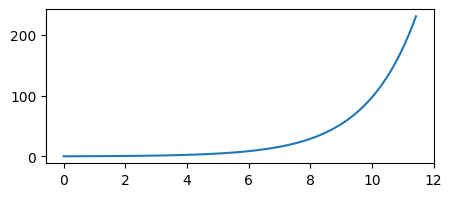

In [3]:
time, response = ctl.step_response(G)
plt.figure(figsize=(5, 2))
plt.plot(time, response)

- Encontrando as características da resposta transitória e permanente

In [4]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  231.03630674117352
tempo de pico:  11.431241212251326
tempo de assentamento:  None
valor final:  231.03630674117352
erro:  230.03630674117352


- Encontrando os polos do sistema

In [5]:
polos = ctl.pole(G)
polos

array([0.60428742+0.j])

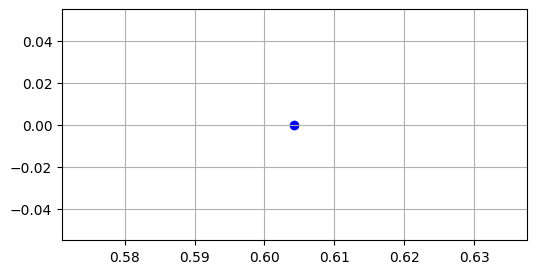

In [6]:
plt.figure(figsize=(6, 3))
plt.scatter(np.real(polos), np.imag(polos), color='blue') 
plt.grid()
plt.show()

# ENCONTRANDO OS PARÂMETROS DESEJADOS
- O primeiro parâmetero é que o erro seja nulo, ou seja $c(\infty) = \lim_{t \to \infty} c(t) = \lim_{s \to 0} s\,C(s) = \lim_{s \to 0} s\,G(s)R(s)= 0$

- O segundo parâmetro se refere à resposta transitória do sistema, ou seja, queremos alguma informação da resposta transitória que nos dê $\zeta$. Um bom parâmetro é o tempo de estabilização $T_s$, gostaria que $T_s$ fosse pequeno.

$T_s = \frac{4}{\zeta \omega_n} \Rightarrow \zeta = \frac{4}{T_s\,\omega_n}$

Mas $\omega_n = \frac{\pi}{T_p\sqrt{1-\zeta²}}$

Então $\zeta = \frac{4}{T_s\,\frac{\pi}{T_p\sqrt{1-\zeta²}}}$

Escolhendo $T_p = 0.2$ e $T_s = 0.4$, temos:

In [7]:
Tp = 0.2
Ts = 0.4
zeta = sp.var('zeta')

eq = sp.Eq(zeta, 4/(Ts*(sp.pi/(Tp*sp.sqrt(1-zeta**2)))))
display(eq)

zeta = float(sp.solve(eq)[0])
zeta

Eq(zeta, 2.0*sqrt(1 - zeta**2)/pi)

0.5370292721463151

In [8]:
Wn = np.pi/(Tp * np.sqrt(1 - zeta**2))
Wn

18.620958891185865

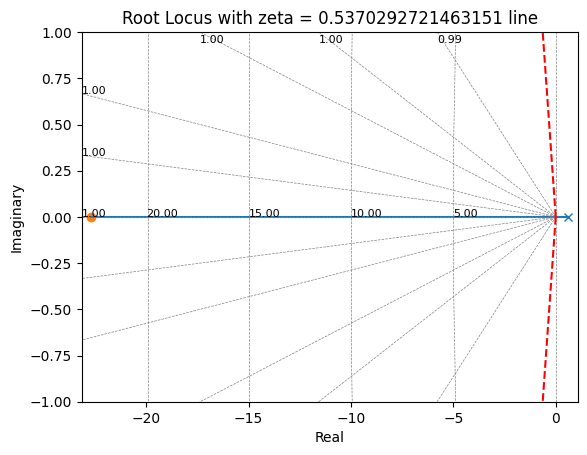

In [9]:
def zGrid(G, zeta):
    ctl.root_locus(G)

    angle  = np.arccos(zeta)
    radius = np.linspace(0, 100, 400)

    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    
    plt.plot(-x, y, 'r--')
    plt.plot(-x, -y, 'r--')

    plt.title(f'Root Locus with zeta = {zeta} line')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()

zGrid(G, zeta)

- Como não há interseção de $\zeta$ com o lugar geométrico, devemos encontrar o zeta de outra forma

In [10]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*sp.I

s_desired = s1
s_desired

-10.0 + 15.707963267949*I

# IMPLEMENTANDO O CONTROLADOR PID
- Encontrando as constantes do controlador: $C(s) = K\frac{(s-a)(s-b)}{s}$

In [11]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr

    return sympy_system

def roundSympyFunction(expr, num_digits=15):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [12]:
s = sp.symbols('s')
K, a, b = sp.symbols('K a b', real=True)

G = sympyFunction(G)
G

(0.00600129017482446*s + 0.136121951905)/(1.0*s - 0.6042874217)

- A função de transferência final em malha aberta será $G(s)C(s)$

In [13]:
C = K * (s - a) * (s - b) / s
GC = G * C

GC

K*(-a + s)*(-b + s)*(0.00600129017482446*s + 0.136121951905)/(s*(1.0*s - 0.6042874217))

In [14]:
ZERO = 1e-10

- Erro em regime permanente para entrada em degrau é igual a zero (malha fechada)

$erro = \frac{1}{1+K_p}$ onde $K_p = \lim_{s\to 0} G(s)$

In [15]:
Kp  = GC.subs(s, ZERO).expand().simplify()
eq1 = 1/(1 + Kp)
eq1 = sp.Eq(eq1, ZERO)
eq1

Eq(1/(K*(-2252602768.81461*a*b + 0.225260276881461*a + 0.225260276881461*b - 2.25260276881461e-11) + 1), 1.0e-10)

- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [16]:
G_aux = GC.subs(s, s_desired)
angle = sp.arg(G_aux)

eq2 = sp.Eq(angle + sp.pi, ZERO)
eq2

Eq(arg(K*(0.0761090501567554 + 0.0942680456264457*I)*(10.0 + 15.707963267949*I)*(10.6042874217 + 15.707963267949*I)*(-a - 10.0 + 15.707963267949*I)*(-b - 10.0 + 15.707963267949*I)) + pi, 1.0e-10)

- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [17]:
G_aux  = GC.subs(s, s_desired)
modulo = sp.Abs(G_aux).expand().simplify()
eq3    = sp.Eq(modulo - 1, ZERO)
eq3

Eq(0.11903873652785*sqrt(0.00288400439142001*a**2 + 0.0576800878284002*a + 1)*sqrt(0.00288400439142001*b**2 + 0.0576800878284002*b + 1)*Abs(K) - 1, 1.0e-10)

In [18]:
def convertString(eq):
    return str(eq.lhs).replace('sqrt', 'np.sqrt').replace('Abs', 'np.abs').replace('pi', 'np.pi').replace('arg', 'np.angle').replace('*I', 'j').replace('I)', '1j)')

str_eq1 = convertString(eq1)
str_eq2 = convertString(eq2)
str_eq3 = convertString(eq3)

print(str_eq1)
print(str_eq2)
print(str_eq3)

1/(K*(-2252602768.81461*a*b + 0.225260276881461*a + 0.225260276881461*b - 2.25260276881461e-11) + 1)
np.angle(K*(0.0761090501567554 + 0.0942680456264457j)*(10.0 + 15.707963267949j)*(10.6042874217 + 15.707963267949j)*(-a - 10.0 + 15.707963267949j)*(-b - 10.0 + 15.707963267949j)) + np.pi
0.11903873652785*np.sqrt(0.00288400439142001*a**2 + 0.0576800878284002*a + 1)*np.sqrt(0.00288400439142001*b**2 + 0.0576800878284002*b + 1)*np.abs(K) - 1


In [19]:
from scipy.optimize import fsolve
import numpy as np

def sistema(variaveis):
    (K, a, b) = variaveis
    return [
        eval(str_eq1), 
        eval(str_eq2),
        eval(str_eq3)
    ]

solutions = fsolve(sistema, [1, 1, 1], maxfev=10000, xtol=ZERO)
print('Solucoes:', solutions, '\n')

Solucoes: [  0.54550156 -81.32374082 -81.06058001] 



/home/klauss/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [20]:
for eq in [eq1, eq2, eq3]:
    sol = eq.lhs.subs({
        K: solutions[0],
        a: solutions[1],
        b: solutions[2]
    })
    print(float(sol))

-1.234503523108524e-13
0.16518166171218956
-0.004623406365491856


In [21]:
K = solutions[0]
a = solutions[1]
b = solutions[2]

K, a, b

(0.5455015616258723, -81.32374082380792, -81.06058001048476)

In [22]:
s = ctl.TransferFunction.s

C = K * (s - a) * (s - b) / s
C

TransferFunction(array([5.45501562e-01, 8.85809006e+01, 3.59602790e+03]), array([1, 0]))

In [23]:
G  = G_bpk
GC = G*C
GC

TransferFunction(array([3.27371316e-03, 6.05854426e-01, 3.36386120e+01, 4.89498337e+02]), array([ 1.        , -0.60428742,  0.        ]))

In [24]:
G_feedback = ctl.feedback(GC, 1)
G_feedback

TransferFunction(array([3.27371316e-03, 6.05854426e-01, 3.36386120e+01, 4.89498337e+02]), array([3.27371316e-03, 1.60585443e+00, 3.30343246e+01, 4.89498337e+02]))

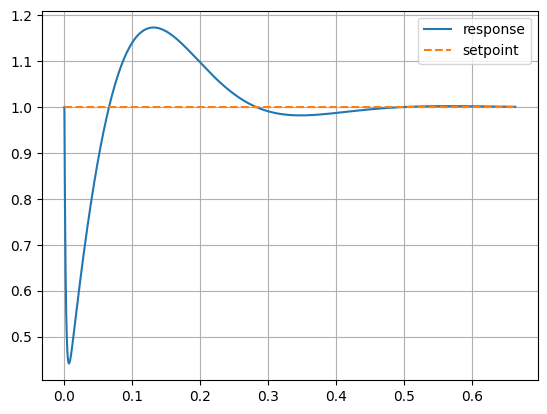

In [28]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, label='response')
plt.plot(time, [1 for i in time], '--', label='setpoint')
plt.legend()
plt.grid()

In [26]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.17260341280767952
valor de pico:  1.1732718914333242
tempo de pico:  0.1311650019928794
tempo de assentamento:  0.25733044112952796
valor final:  1.0005700807437052
erro:  0.0005700807437052369
